# COMMOT (Modified) — Toy Demo with Modulators (Jupyter)

這份 Notebook 會：
1. 準備一個極小的 AnnData（6 個 cell × 4 個基因）。
2. 定義兩組配受體（其中一組為**異質複合體**）。
3. 建立四類調節向量（AG/AN/CS/CI），對異質複合體自動以 `min/ave` 聚合。
4. 呼叫我們改造後的 `spatial_communication`（含 $K' = M\,e^{-C/\varepsilon}$ 與修改版 Sinkhorn）。
5. 視覺化：耦合矩陣熱圖、空間散點、sender/receiver 彙總。

In [1]:
# Imports
import sys, os
import numpy as np
import pandas as pd
import anndata
import matplotlib.pyplot as plt

# 讓本地的 commot_mod/ 可被匯入（請把本 Notebook 放在專案根目錄）
sys.path.insert(0, os.getcwd())
from commot_mod import spatial_communication
print("Python:", sys.executable)

Python: c:\Users\user\Desktop\研究所訓練\碩論\.venv\Scripts\python.exe


## 1) 準備一筆小資料

In [3]:
genes = ["LigA", "RecA", "Tgfbr1", "Tgfbr2"]
X = np.array([
    [3.0, 0.2, 0.1, 0.1],
    [2.5, 0.1, 0.1, 0.1],
    [0.2, 2.8, 0.3, 0.2],
    [0.2, 2.2, 0.2, 0.2],
    [0.2, 0.3, 2.5, 2.6],
    [0.2, 0.3, 2.2, 2.4],
], float)
adata = anndata.AnnData(X=X, var=pd.DataFrame(index=genes))
adata.obsm["spatial"] = np.array([
    [0.0, 0.0],
    [0.6, 0.1],
    [1.2, 0.0],
    [1.8, 0.1],
    [1.1, 0.9],
    [1.7, 1.0],
], float)
adata

AnnData object with n_obs × n_vars = 6 × 4
    obsm: 'spatial'

In [4]:
import numpy as np
from scipy.spatial import distance_matrix

D = distance_matrix(adata.obsm['spatial'], adata.obsm['spatial'])
thr = 1.2  # 你現在用的 dis_thr；如果你換了，請改成對應值
C = D.copy(); C[D > thr] = np.inf
finite = np.isfinite(C).sum()
print("finite entries:", finite, " out of ", C.size)

finite entries: 26  out of  36


In [5]:
thr = 1.2
D = distance_matrix(adata.obsm['spatial'], adata.obsm['spatial'])
C = D.copy(); C[D > thr] = np.inf

for eps in [0.1, 0.3, 0.5, 1.0, 1.5, 2.0]:
    K = np.exp(-C/eps)
    K[~np.isfinite(C)] = 0.0
    print(f"eps={eps:<4}  K.max={K.max():.3e}  K.sum={K.sum():.3e}")

eps=0.1   K.max=1.000e+00  K.sum=6.019e+00
eps=0.3   K.max=1.000e+00  K.sum=7.477e+00
eps=0.5   K.max=1.000e+00  K.sum=9.961e+00
eps=1.0   K.max=1.000e+00  K.sum=1.470e+01
eps=1.5   K.max=1.000e+00  K.sum=1.742e+01
eps=2.0   K.max=1.000e+00  K.sum=1.911e+01


## 2) 定義配受體（含異質複合體）

In [6]:
df_ligrec = pd.DataFrame([
    ["LigA", "RecA", "PathwayX"],
    ["LigA", "Tgfbr1_Tgfbr2", "PathwayX"],
], columns=["ligand","receptor","pathway"])
df_ligrec

,ligand,receptor,pathway
0,LigA,RecA,PathwayX
1,LigA,Tgfbr1_Tgfbr2,PathwayX


In [7]:
lig, rec = "LigA", "RecA"
a = adata[:, lig].X.A1 if hasattr(adata[:, lig].X, "A1") else adata[:, lig].X.ravel()
b = adata[:, rec].X.A1 if hasattr(adata[:, rec].X, "A1") else adata[:, rec].X.ravel()
print("a: sum/min/max =", float(a.sum()), float(a.min()), float(a.max()))
print("b: sum/min/max =", float(b.sum()), float(b.min()), float(b.max()))

a: sum/min/max = 6.300000000000001 0.2 3.0
b: sum/min/max = 5.8999999999999995 0.1 2.8


## 3) 四類調節向量（AG/AN/CS/CI）

In [8]:
AG_LigA = np.array([0.5,0.6,0.1,0.1,0.1,0.1])
AN_LigA = np.array([0.0,0.0,0.2,0.2,0.2,0.2])
CS_RecA = np.array([0.1,0.1,0.7,0.7,0.1,0.1])
CI_RecA = np.array([0.2,0.2,0.0,0.0,0.2,0.2])
CS_Tgfbr1 = np.array([0.1,0.1,0.2,0.3,0.8,0.7])
CS_Tgfbr2 = np.array([0.1,0.1,0.2,0.3,0.7,0.8])
CI_Tgfbr1 = np.array([0.2,0.2,0.3,0.3,0.0,0.1])
CI_Tgfbr2 = np.array([0.2,0.2,0.3,0.3,0.1,0.0])

modulators = {
    "AG": {"LigA": AG_LigA},
    "AN": {"LigA": AN_LigA},
    "CS": {"RecA": CS_RecA, "Tgfbr1": CS_Tgfbr1, "Tgfbr2": CS_Tgfbr2},
    "CI": {"RecA": CI_RecA, "Tgfbr1": CI_Tgfbr1, "Tgfbr2": CI_Tgfbr2},
}
modulators

{'AG': {'LigA': array([0.5, 0.6, 0.1, 0.1, 0.1, 0.1])},
 'AN': {'LigA': array([0. , 0. , 0.2, 0.2, 0.2, 0.2])},
 'CS': {'RecA': array([0.1, 0.1, 0.7, 0.7, 0.1, 0.1]),
  'Tgfbr1': array([0.1, 0.1, 0.2, 0.3, 0.8, 0.7]),
  'Tgfbr2': array([0.1, 0.1, 0.2, 0.3, 0.7, 0.8])},
 'CI': {'RecA': array([0.2, 0.2, 0. , 0. , 0.2, 0.2]),
  'Tgfbr1': array([0.2, 0.2, 0.3, 0.3, 0. , 0.1]),
  'Tgfbr2': array([0.2, 0.2, 0.3, 0.3, 0.1, 0. ])}}

a sum/min/max: 6.300000000000001 0.2 3.0
b sum/min/max: 5.8999999999999995 0.1 2.8
M min/max/sum: 0.7346938775489212 5.279999999978881 62.772244897739164
rows with >=1 valid col: 6 / 6   (min per-row valid = 3 )
cols with >=1 valid row: 6 / 6   (min per-col valid = 3 )
logKp finite ratio: 26 / 36
Any NaN in logKp? False
P sum = 5.574746428078263


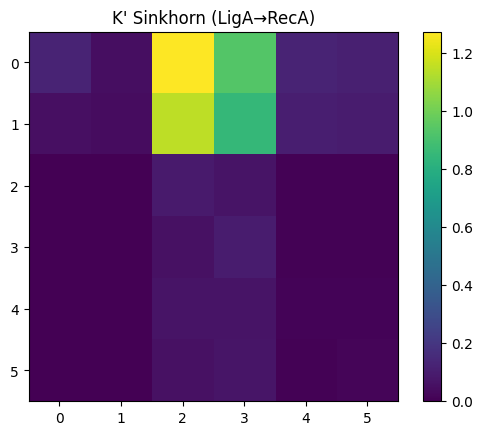

In [9]:
# 以 LigA→RecA 測一格
from scipy.spatial import distance_matrix
lig, rec = "LigA", "RecA"
a = adata[:, lig].X.A1 if hasattr(adata[:, lig].X, "A1") else adata[:, lig].X.ravel()
b = adata[:, rec].X.A1 if hasattr(adata[:, rec].X, "A1") else adata[:, rec].X.ravel()

# M 來自你的 modulators（或先用全 1 比 baseline）
from commot_mod.modulators import make_M
AG = modulators.get("AG", {}).get(lig)
AN = modulators.get("AN", {}).get(lig)
CS = modulators.get("CS", {}).get(rec)
CI = modulators.get("CI", {}).get(rec)
M = make_M(a, b, AG=AG, AN=AN, CS=CS, CI=CI, Kh=0.5)

print("a sum/min/max:", float(a.sum()), float(a.min()), float(a.max()))
print("b sum/min/max:", float(b.sum()), float(b.min()), float(b.max()))
print("M min/max/sum:", float(M.min()), float(M.max()), float(M.sum()))

mask = np.isfinite(C) & (M > 0)
row_ok = mask.sum(axis=1)
col_ok = mask.sum(axis=0)
print("rows with >=1 valid col:", int((row_ok>0).sum()), "/", C.shape[0], "  (min per-row valid =", int(row_ok.min()), ")")
print("cols with >=1 valid row:", int((col_ok>0).sum()), "/", C.shape[1], "  (min per-col valid =", int(col_ok.min()), ")")

eps = 1.5  # 用你跑的值
logKp = np.full_like(C, -np.inf, float)
logKp[mask] = np.log(M[mask]) - C[mask]/eps
print("logKp finite ratio:", np.isfinite(logKp).sum(), "/", logKp.size)
print("Any NaN in logKp?", np.isnan(logKp).any())

D = distance_matrix(adata.obsm["spatial"], adata.obsm["spatial"])
C = D.copy(); C[D > 2.0] = np.inf  # 放寬距離看看
from commot_mod.sinkhorn import unot_sinkhorn_l1_dense_modified
P = unot_sinkhorn_l1_dense_modified(
    a, b, C,
    eps=1.5,
    m=2.0,            
    M=M,
    nitermax=2000,    
)

print("P sum =", float(P.sum()))
import matplotlib.pyplot as plt
plt.figure(); plt.imshow(P, vmin=0); plt.colorbar(); plt.title("K' Sinkhorn (LigA→RecA)"); plt.show()


## 4) 執行改造後的 `spatial_communication`

In [28]:
from scipy.spatial import distance_matrix
lig, rec = "LigA", "RecA"
a = adata[:, lig].X.A1 if hasattr(adata[:, lig].X, "A1") else adata[:, lig].X.ravel()
b = adata[:, rec].X.A1 if hasattr(adata[:, rec].X, "A1") else adata[:, rec].X.ravel()

# M 來自你的 modulators（或先用全 1 比 baseline）
from commot_mod.modulators import make_M
AG = modulators.get("AG", {}).get(lig)
AN = modulators.get("AN", {}).get(lig)
CS = modulators.get("CS", {}).get(rec)
CI = modulators.get("CI", {}).get(rec)
M = make_M(a, b, AG=AG, AN=AN, CS=CS, CI=CI, Kh=0.5)

D = distance_matrix(adata.obsm["spatial"], adata.obsm["spatial"])
C = D.copy(); C[D > 2.0] = np.inf  # 放寬距離看看
from commot_mod.sinkhorn import unot_sinkhorn_l1_dense_modified
P = unot_sinkhorn_l1_dense_modified(C, a, b, eps=1.5, rho=2.0, M=M, n_iter=2000)

print("P sum =", float(P.sum()))
import matplotlib.pyplot as plt
plt.figure(); plt.imshow(P, vmin=0); plt.colorbar(); plt.title("K' Sinkhorn (LigA→RecA)"); plt.show()

ImportError: cannot import name 'unot_sinkhorn_l1_dense_modified' from 'commot_mod.sinkhorn' (c:\Users\user\Desktop\研究所訓練\碩論\commot_mod\sinkhorn.py)

In [ ]:
spatial_communication(
    adata,
    database_name="toyDB",
    df_ligrec=df_ligrec,
    pathway_sum=True,
    heteromeric=True,
    heteromeric_rule="min",   # 可改成 "ave" 比較
    dis_thr=1.2,
    cost_type="euc",
    cot_eps_p=1e-1,
    cot_rho=1e1,
    modulators=modulators,
    hill_Kh=0.5,
)
list(adata.obsp.keys())

c:\Users\user\Desktop\研究所訓練\碩論\commot_mod\api.py:44: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lig = str(df_ligrec.iloc[i][0])
c:\Users\user\Desktop\研究所訓練\碩論\commot_mod\api.py:45: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  rec = str(df_ligrec.iloc[i][1])
c:\Users\user\Desktop\研究所訓練\碩論\commot_mod\api.py:55: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row.append(df_ligrec.iloc[i][2])


['commot-toyDB-LigA-RecA',
 'commot-toyDB-LigA-Tgfbr1_Tgfbr2',
 'commot-toyDB-PathwayX',
 'commot-toyDB-total-total']

## 5) 視覺化
不使用 seaborn；每張圖單獨一個 figure；不指定任何顏色。

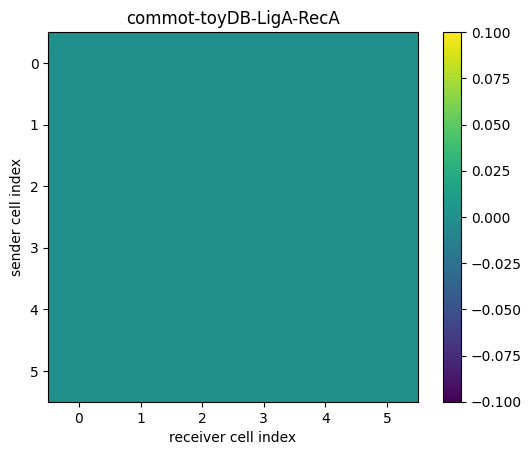

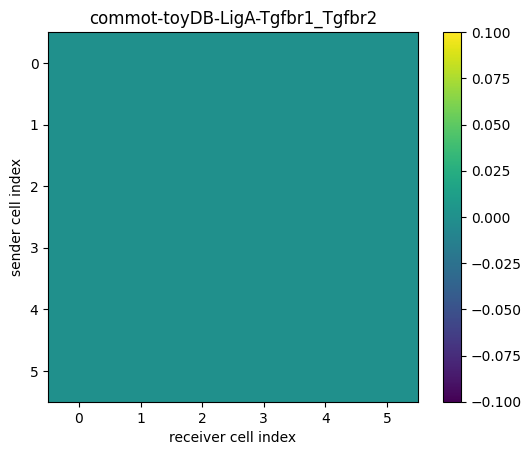

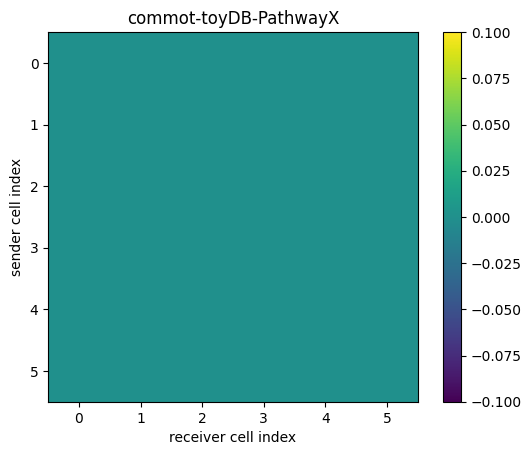

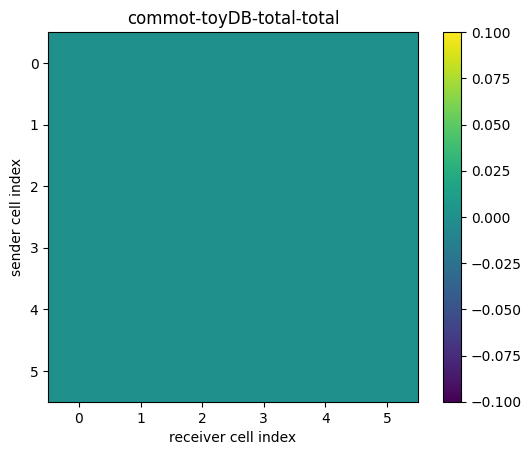

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def show_heatmap(key):
    mat = adata.obsp[key]
    M = mat.toarray() if hasattr(mat, "toarray") else np.asarray(mat)
    plt.figure()
    plt.imshow(M)
    plt.title(key)
    plt.colorbar()
    plt.xlabel("receiver cell index")
    plt.ylabel("sender cell index")
    plt.show()

keys_to_plot = [k for k in adata.obsp.keys() if k.startswith("commot-toyDB-")]
for k in sorted(keys_to_plot):
    show_heatmap(k)

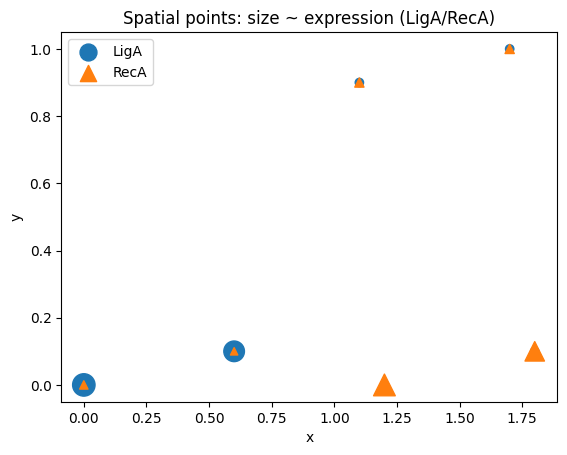

In [8]:
# 空間散點：顯示 LigA 和 RecA 的表達大小（用點大小表現）
plt.figure()
xy = adata.obsm["spatial"]
LigA = adata[:, "LigA"].X.A1 if hasattr(adata[:, "LigA"].X, 'A1') else adata[:, "LigA"].X.ravel()
RecA = adata[:, "RecA"].X.A1 if hasattr(adata[:, "RecA"].X, 'A1') else adata[:, "RecA"].X.ravel()
plt.scatter(xy[:,0], xy[:,1], s=20 + 80*LigA, label="LigA")
plt.scatter(xy[:,0], xy[:,1], s=20 + 80*RecA, label="RecA", marker='^')
plt.legend(); plt.title("Spatial points: size ~ expression (LigA/RecA)")
plt.xlabel("x"); plt.ylabel("y"); plt.show()

<Figure size 640x480 with 0 Axes>

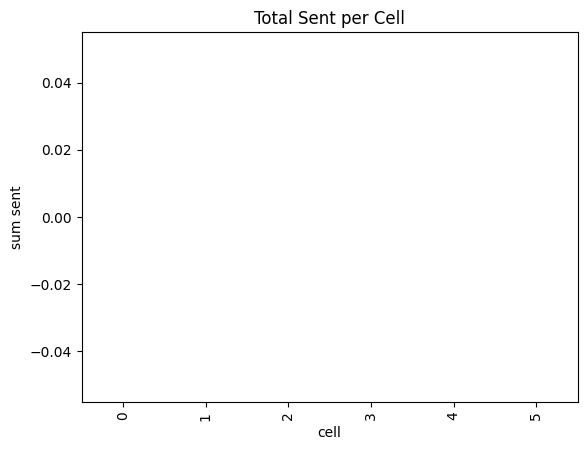

<Figure size 640x480 with 0 Axes>

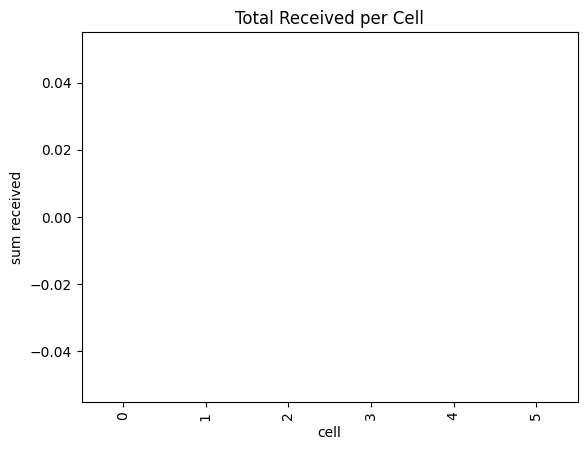

In [9]:
# Sender / Receiver 彙總長條圖
sender = adata.obsm["commot-toyDB-sum-sender"][['s-total-total']]
receiver = adata.obsm["commot-toyDB-sum-receiver"][['r-total-total']]

plt.figure(); sender.plot(kind='bar', legend=False)
plt.title("Total Sent per Cell"); plt.xlabel("cell"); plt.ylabel("sum sent")
plt.show()

plt.figure(); receiver.plot(kind='bar', legend=False)
plt.title("Total Received per Cell"); plt.xlabel("cell"); plt.ylabel("sum received")
plt.show()